In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv('market_day_level.csv',parse_dates=['trans_date'])
data = data.drop(['Unnamed: 0'],axis=1).rename(columns={'Unnamed: 0.1':'Weighted_Price'})

In [3]:
data['trans_date'] = data['trans_date'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='trans_date', freq='D')]).first().reset_index()
data = data.set_index('trans_date')


In [4]:
split_date = '2020-01-01'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

In [29]:
data_train

,Weighted_Price,Open,High,Low,Close,Volume BTC,Volume USD
trans_date,,,,,,,
2017-01-01,719.5,977.253208,977.418333,977.095722,977.268465,6.313666,6215.613316
2017-01-02,2159.5,1012.263160,1012.541111,1011.959785,1012.273903,6.240900,6320.823541
2017-01-03,3599.5,1019.987431,1020.246257,1019.755146,1020.040472,6.866814,7006.929346
2017-01-04,5039.5,1076.552882,1077.291757,1075.523986,1076.553639,15.693348,17052.837734
2017-01-05,6479.5,1043.609160,1044.932715,1042.048319,1043.547951,25.459151,25625.674044
...,...,...,...,...,...,...,...
2019-12-28,1571759.5,7298.380646,7301.259604,7295.641701,7298.453410,1.118904,8165.736670
2019-12-29,1573199.5,7344.713694,7347.246958,7342.418618,7344.867285,1.836150,13587.135118
2019-12-30,1574639.5,7297.675146,7300.186924,7295.122361,7297.834056,2.591312,18867.496874


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1540 entries, 2017-01-01 to 2021-03-20
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Weighted_Price  1540 non-null   float64
 1   Open            1540 non-null   float64
 2   High            1540 non-null   float64
 3   Low             1540 non-null   float64
 4   Close           1540 non-null   float64
 5   Volume BTC      1540 non-null   float64
 6   Volume USD      1540 non-null   float64
dtypes: float64(7)
memory usage: 96.2 KB


In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

def bit_pre_process(raw_data , seq_len, column = 1):
  
  #Select the feature/column 
  data = raw_data.iloc[:, column].values
  data = data.reshape(-1, 1)
  
  #Feature Scaling
  data = sc.fit_transform(data)
  
  #Making sequences
  
  X = []
  y = []

  for i in range(seq_len, len(data)):
      X.append(data[i-seq_len:i, 0])
      y.append(data[i, 0])
  X, y = np.array(X), np.array(y)

  # Reshaping
  X = np.reshape(X, (X.shape[0], X.shape[1], 1))
  
  return X, y

In [7]:
#Setting the sequence length (Try different values)
sequence_length = 60

#Choosing the idex of the Close column
comumn_index= 4

#Preprocessing the training set
X_train, y_train = bit_pre_process(data_train , sequence_length, comumn_index)

In [26]:
X_train.shape

(1036, 60, 1)

In [9]:
y_train.shape

(1036,)

In [10]:
#Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#Initialising the RNN
regressor = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

#Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

In [11]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae', 'mape'])

In [12]:
regressor.fit(X_train, y_train, epochs = 50, batch_size = 50)

Epoch 1/50
21/21 [==============================] - 7s 85ms/step - loss: 0.0550 - mse: 0.0550 - mae: 0.1772 - mape: 82.2367
Epoch 2/50
21/21 [==============================] - 2s 79ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0747 - mape: 56.6477
Epoch 3/50
21/21 [==============================] - 2s 77ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0532 - mape: 20.1293
Epoch 4/50
21/21 [==============================] - 2s 76ms/step - loss: 0.0063 - mse: 0.0063 - mae: 0.0535 - mape: 25.3154
Epoch 5/50
21/21 [==============================] - 2s 85ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0509 - mape: 21.0614
Epoch 6/50
21/21 [==============================] - 2s 88ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0479 - mape: 18.0134
Epoch 7/50
21/21 [==============================] - 2s 87ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0476 - mape: 21.2249
Epoch 8/50
21/21 [==============================] - 2s 87ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0444 - mape: 16.9591
Epoch 9/

In [13]:
#Adding the previous 60 days cosing price to the test data
test_set = pd.concat((data_train.tail(sequence_length), data_test), axis = 0)

In [14]:
x_test, y_true = bit_pre_process(test_set , sequence_length, comumn_index)

In [15]:
x_test.shape,y_true.shape

((444, 60, 1), (444,))

In [28]:
test_set

,Weighted_Price,Open,High,Low,Close,Volume BTC,Volume USD
trans_date,,,,,,,
2019-11-03,1492559.5,9216.973229,9222.163139,9214.026743,9217.951722,1.771343,16262.558857
2019-11-04,1493999.5,9254.543611,9260.796958,9250.866951,9255.588271,3.451331,32234.006093
2019-11-05,1495439.5,9342.235674,9348.219507,9338.224764,9342.998597,3.458063,32256.611319
2019-11-06,1496879.5,9335.322576,9339.182715,9332.254111,9335.835583,3.262743,30472.001756
2019-11-07,1498319.5,9237.890306,9241.245632,9234.401576,9238.378458,2.793858,25756.308382
...,...,...,...,...,...,...,...
2021-03-16,2209680.5,55342.874889,55388.028125,55297.895611,55343.697083,5.370296,295599.768827
2021-03-17,2211120.5,56158.036813,56200.458931,56118.449000,56160.989236,4.055609,228489.573523
2021-03-18,2212560.5,58475.809778,58511.486535,58437.665014,58476.000361,3.830878,224455.585754


In [16]:
#Predicting the closing price of the test data
predicted_stock_price = regressor.predict(x_test)

In [17]:
#Inversing the scaled values 
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [18]:
#Inversing the scaled actual prices from test data
real_stock_price = sc.inverse_transform(y_true.reshape(-1, 1))

In [19]:
def plot_predictions(actual_price, predicted_price, title, x_label, y_label):
  plt.plot(actual_price, color = 'green', label = 'Actual Stock Price')
  plt.plot(predicted_price, color = 'red', label = 'Predicted Stock Price')
  plt.title(title)
  plt.xlabel('Time')
  plt.ylabel('Bitcoin Stock Price')
  plt.legend()
  plt.show()

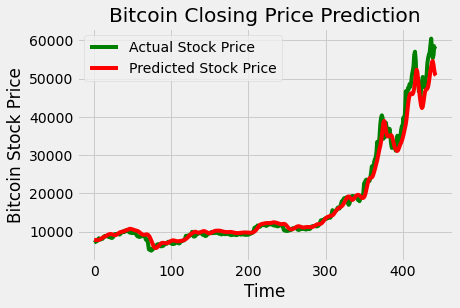

In [20]:
plot_predictions(real_stock_price, predicted_stock_price, "Bitcoin Closing Price Prediction", "Time", "Closing Price")

In [21]:
data_test['Predicted_Close'] = predicted_stock_price

In [22]:
compare = data_test[['Close','Predicted_Close' ]]

In [24]:
compare

,Close,Predicted_Close
trans_date,,
2020-01-02,7072.435687,7805.529297
2020-01-03,7217.607403,7789.124512
2020-01-04,7321.510688,7766.354492
2020-01-05,7429.768535,7746.637695
2020-01-06,7533.281097,7740.130371
...,...,...
2021-03-16,55343.697083,54593.078125
2021-03-17,56160.989236,53617.867188
2021-03-18,58476.000361,52099.945312
